In [7]:
import torch #1.3.1
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera
from tqdm.notebook import tqdm
from IPython.display import Video
from torch.distributions import Gamma 

In [132]:
class bearing():
    def __init__(self,sensor_no,bearing,time):
        self.sensor_no = sensor_no #can be 0 or 1
        self.sensor_location = np.array([[0,0],[15000,15000]])[sensor_no]
        self.bearing = bearing
        self.time = time
        self.track_id = 0 #for multiple target evaluations
A = lambda Ts: np.array([[1, 0, Ts, 0],[0, 1, 0, Ts], [0, 0, 1, 0],[0, 0, 0, 1]])
B = lambda ts: np.concatenate(((ts**2)*0.5*np.eye(2), ts * np.eye(2)), axis = 0)
aci = lambda konum, sensor_no: np.rad2deg(np.arctan2(konum[0] - sensor_locations[sensor_no][0], konum[1] - sensor_locations[sensor_no][1])) #x vey y ozellikle boyle (x,y)

def generate_a_target(measurement_sigma, process_noise, ts, sensor_locations = np.array([[0,0],[15000,15000]])):
    initial_positions = np.random.rand(2) *15000
    initial_velocities = np.random.rand(1) *10 #m/s
    initial_orientation = np.random.rand(1) * 360
    print(initial_orientation)
    dx = initial_velocities * np.cos(np.deg2rad(90 - initial_orientation))
    dy = initial_velocities * np.sin(np.deg2rad(90 - initial_orientation))
    temp_time_array = np.linspace(0,100,100 / ts)
    time_array = np.sort(np.concatenate((temp_time_array, temp_time_array + np.random.rand(1,int(100 / ts))), axis=None))
    car_traj = [np.concatenate((initial_positions, dx, dy), axis=None)]
    bearings = [bearing(0,aci(car_traj[0],0),time_array[0])]
    for i in range(1,len(time_array)):
        car_traj.append((np.matmul(A(time_array[i]-time_array[i-1]),car_traj[-1].T).T + np.matmul(B(time_array[i]-time_array[i-1]), np.random.normal(0, process_noise, (2,1))).T * process_noise)[0])
    coordinates = np.array(car_traj)[:,0:2]
    for i in range(1,len(car_traj)):
        a = np.random.choice([False,True], p = [0.5,0.5])
        if a:
            bearings.append(bearing(0,aci(car_traj[i],0) + Gamma(torch.tensor([0.6]), torch.tensor([1.0])).rsample(sample_shape = (1,1))[0][0],time_array[i]))
        else:
            bearings.append(bearing(1,aci(car_traj[i],1) + Gamma(torch.tensor([0.6]), torch.tensor([1.0])).rsample(sample_shape = (1,1))[0][0],time_array[i])) 
    return car_traj, bearings, coordinates

## Target Create
Single-target scenerio. If you can use "thread" (known associations), just customize "bearing" object with "track_id" and create a model accordingly.


[71.40924785]


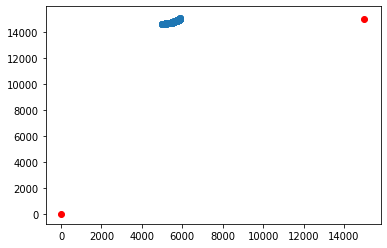

In [133]:
measurement_sigma = np.sqrt(1);
process_noise = np.sqrt(1);
sensor_locations = np.array([[0,0],[15000,15000]])
ts = 1/2
car_traj, bearings, coordinates = generate_a_target(measurement_sigma, process_noise, ts)
plt.scatter(coordinates[:,0],coordinates[:,1])
plt.scatter(sensor_locations[0][0],sensor_locations[0][1], c = "red")
plt.scatter(sensor_locations[1][0],sensor_locations[1][1], c = "red")

## Particle Filtering
We assume that we know initial point of the target.

In [134]:
N = 2000
h = lambda particles, bearing: 90 - (torch.atan2(particles[:,1] - bearing.sensor_location[1],particles[:,0] - bearing.sensor_location[0]) * 57.295779513)
initial_state = torch.Tensor(car_traj[0])
initial_covarience_matrix = torch.diag(torch.Tensor([10**2,10**2,10,10]))
initial_sampling = torch.distributions.MultivariateNormal(loc= initial_state,covariance_matrix = initial_covarience_matrix)
particles = torch.squeeze(initial_sampling.expand([N, 1]).sample())
weights = torch.ones(N) / N

In [135]:
def residual_resample(weights):
    """ Performs the residual resampling algorithm used by particle filters.
    Based on observation that we don't need to use random numbers to select
    most of the weights. Take int(N*w^i) samples of each particle i, and then
    resample any remaining using a standard resampling algorithm [1]
    Parameters
    ----------
    weights : list-like of float
        list of weights as floats
    Returns
    -------
    indexes : ndarray of ints
        array of indexes into the weights defining the resample. i.e. the
        index of the zeroth resample is indexes[0], etc.
    References
    ----------
    .. [1] J. S. Liu and R. Chen. Sequential Monte Carlo methods for dynamic
       systems. Journal of the American Statistical Association,
       93(443):1032–1044, 1998.
    """

    N = len(weights)
    #indexes = np.zeros(N, 'i')
    indexes=torch.zeros(N,dtype=torch.int32)
    # take int(N*w) copies of each weight, which ensures particles with the
    # same weight are drawn uniformly
    #num_copies = (np.floor(N*np.asarray(weights))).astype(int)
    num_copies = (torch.floor(N*torch.as_tensor(weights))).int()
    k = 0
    for i in range(N):
        for _ in range(num_copies[i]): # make n copies
            indexes[k] = i
            k += 1

    # use multinormal resample on the residual to fill up the rest. This
    # maximizes the variance of the samples
    residual = weights - num_copies     # get fractional part
    residual /= sum(residual)           # normalize
    #cumulative_sum = np.cumsum(residual)
    cumulative_sum = torch.cumsum(residual,dim=0)
    cumulative_sum[-1] = 1. # avoid round-off errors: ensures sum is exactly one
    indexes[k:N] = np.searchsorted(cumulative_sum, random(N-k))

    return indexes



def stratified_resample(weights):
    """ Performs the stratified resampling algorithm used by particle filters.
    This algorithms aims to make selections relatively uniformly across the
    particles. It divides the cumulative sum of the weights into N equal
    divisions, and then selects one particle randomly from each division. This
    guarantees that each sample is between 0 and 2/N apart.
    Parameters
    ----------
    weights : list-like of float
        list of weights as floats
    Returns
    -------
    indexes : ndarray of ints
        array of indexes into the weights defining the resample. i.e. the
        index of the zeroth resample is indexes[0], etc.
    """

    N = len(weights)
    # make N subdivisions, and chose a random position within each one
    #positions = (random(N) + range(N)) / N
    positions = (torch.rand(N) + torch.arange(N)) / N

    #indexes = np.zeros(N, 'i')
    indexes=torch.zeros(N,dtype=torch.int32)
    #cumulative_sum = np.cumsum(weights)
    cumulative_sum = torch.cumsum(weights,dim=0)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes


def systematic_resample(weights):
    """ Performs the systemic resampling algorithm used by particle filters.
    This algorithm separates the sample space into N divisions. A single random
    offset is used to to choose where to sample from for all divisions. This
    guarantees that every sample is exactly 1/N apart.
    Parameters
    ----------
    weights : list-like of float
        list of weights as floats
    Returns
    -------
    indexes : ndarray of ints
        array of indexes into the weights defining the resample. i.e. the
        index of the zeroth resample is indexes[0], etc.
    """
    N = len(weights)

    # make N subdivisions, and choose positions with a consistent random offset
    #positions = (random() + np.arange(N)) / N
    positions = (torch.rand(1) + torch.arange(N)) / N

    #indexes = np.zeros(N, 'i')
    indexes=torch.zeros(N,dtype=torch.int32)
    #cumulative_sum = np.cumsum(weights)
    cumulative_sum = torch.cumsum(weights,dim=0)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes
def update(particles, weights, bearing, sigma, h_func):
    v = bearing.bearing - h_func(particles,bearing)
    v[(v < -170) * (v > -190)] += 180 
    v[(v < -350) * (v > -370)] += 360
    v[(v < 190) * (v > 170)] -= 180
    v[(v < 370) * (v > 350)] -= 360
    weigths = weights * Gamma(torch.tensor([1.0]), torch.tensor([0.6])).log_prob(torch.abs(v)).exp()  
    weights = weigths + torch.Tensor([1.e-300])     # avoid round-off to zero
    weights = weigths / torch.sum(weights) # normalize
    return weights
def predict(particles, ts=torch.Tensor([1.])):
    """ 
    One step propagation. It is linear in Bearing-Only-Tracking.
    """
    particles = torch.matmul(particles,torch.t(torch.tensor(A(ts)).float())) 
    particles += torch.transpose(torch.mm(torch.Tensor(B(ts.numpy())),torch.empty([2,len(particles)]).normal_(mean=0,std=process_noise)),0,1)
    return particles
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""
    mean = torch.sum(torch.mul(particles,weights[None].transpose_(0, 1)),dim=0)
    var = torch.sum(torch.mul((particles - mean).pow(2),weights[None].transpose_(0, 1)),dim=0)
    return mean, var

def neff(weights):
    return 1. / torch.dot(weights,weights)

def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes.long()]
    weights[:] = weights[indexes.long()]
    weights = torch.full(weights.shape, 1.0 / len(weights))
    return weights,particles
def generate_video(particles, weights, bearings, video_name):
    takip = []
    old_time = bearings[0].time
    plot = True
    fig = plt.figure(figsize=(16,9))
    camera = Camera(fig)
    N = len(particles)
    sel=0
    for bearing in tqdm(bearings[1:]):
        particles = predict(particles, ts = torch.Tensor([bearing.time - old_time]))
        weights = update(particles, weights, bearing, sigma = measurement_sigma, h_func = h)
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            weights,particles=resample_from_index(particles, weights, indexes)

        mean, var = estimate(particles, weights)
        takip.append(mean)

        if plot:
                alpha = .20
                if N > 5000:
                    alpha *= np.sqrt(5000)/np.sqrt(N)           
                plt.scatter(particles[:, 0], particles[:, 1], 
                            alpha=alpha, color='g')

        plt.scatter(coordinates[0:sel,0], coordinates[0:sel,1], marker='+',color='y', s=180, lw=3)
        plt.scatter(mean[0], mean[1], marker='+',color='r', s=180, lw=3)
        plt.scatter(sensor_locations[0][0],sensor_locations[0][1], c = "red")
        plt.scatter(sensor_locations[1][0],sensor_locations[1][1], c = "red")

        if bearing.sensor_no==1:
            slope=np.tan(np.deg2rad(-bearing.bearing-90))
            y_slope=np.arange(3000,0,-10*slope)
            x_slope=np.arange(3000,0,-10)
            if len(y_slope)>len(x_slope):
                plt.plot(x_slope,y_slope[0:len(x_slope)],alpha=0.2)
            else:
                plt.plot(x_slope[0:len(y_slope)],y_slope,alpha=0.2)

        else:
            slope=np.tan(np.deg2rad(bearing.bearing))
            y_slope=np.arange(0,3000,10)
            x_slope=np.arange(0,3000,10*slope)
            if len(y_slope)>len(x_slope):
                plt.plot(x_slope,y_slope[0:len(x_slope)],alpha=0.2)
            else:
                plt.plot(x_slope[0:len(y_slope)],y_slope,alpha=0.2)


        old_time = bearing.time
        camera.snap()
        sel+=1

    animation = camera.animate()
    animation.save(video_name)
    plt.close()
    
    Video(video_name)
def one_target(particles, weights, bearings):
    mean, var = estimate(particles, weights)
    takip = [mean]
    old_time = bearings[0].time
    for bearing in tqdm(bearings[1:]):
        N = len(particles)
        particles = predict(particles, ts = torch.Tensor([bearing.time - old_time]))
        weights = update(particles, weights, bearing, sigma = measurement_sigma, h_func = h)
        # resample if too few effective particles
        print(weights)
        if neff(weights) < N/2:
            print("selam")
            indexes = systematic_resample(weights)
#             print("--------------------")
#             print(weights)
            weights,particles=resample_from_index(particles, weights, indexes)
            

        mean, var = estimate(particles, weights)
        takip.append(mean)
        old_time = bearing.time
    
    return torch.stack(takip)
def performance(takip, car_traj):
    ind_error = (takip - torch.Tensor(car_traj))[:,:2]
    rmse = torch.sqrt(torch.mean(torch.sum(ind_error.pow(2), dim = 1)))
    return rmse.data.numpy(), torch.sqrt(torch.sum(ind_error.pow(2), dim = 1)).data.numpy()

In [116]:
Gamma(torch.tensor([0.6]), torch.tensor([1.0])).log_prob(1)


tensor([-1.3982])

In [ ]:
gamma.logpdf(2,1,1)

In [93]:
from scipy.stats import gamma

In [136]:
takip = one_target(particles, weights, bearings)



tensor([0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005])
tensor([0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005])
tensor([0.0004, 0.0006, 0.0005,  ..., 0.0005, 0.0005, 0.0005])
tensor([0.0004, 0.0007, 0.0005,  ..., 0.0004, 0.0005, 0.0005])
tensor([0.0004, 0.0006, 0.0006,  ..., 0.0004, 0.0005, 0.0005])
tensor([0.0003, 0.0007, 0.0006,  ..., 0.0004, 0.0004, 0.0006])
tensor([0.0003, 0.0006, 0.0006,  ..., 0.0004, 0.0005, 0.0006])
tensor([0.0003, 0.0006, 0.0006,  ..., 0.0004, 0.0004, 0.0006])
tensor([0.0003, 0.0006, 0.0006,  ..., 0.0004, 0.0004, 0.0006])
tensor([0.0003, 0.0005, 0.0006,  ..., 0.0004, 0.0005, 0.0006])
tensor([0.0003, 0.0005, 0.0006,  ..., 0.0004, 0.0005, 0.0006])
tensor([0.0003, 0.0005, 0.0006,  ..., 0.0004, 0.0005, 0.0006])
tensor([0.0003, 0.0005, 0.0006,  ..., 0.0004, 0.0004, 0.0006])
tensor([0.0003, 0.0005, 0.0006,  ..., 0.0004, 0.0004, 0.0006])
tensor([0.0002, 0.0006, 0.0006,  ..., 0.0004, 0.0004, 0.0007])
tensor([0.0002, 0.0006, 0.0006,  ..., 0.0004, 0.0004, 0

tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([nan, nan, nan,  ..., nan, nan, nan])
tensor([na

In [103]:
rmse = performance(takip, car_traj)
rmse[0]

array(nan, dtype=float32)

In [123]:
video_name = "sil3.mp4"
generate_video(particles, weights, bearings, video_name)

# Monte Carlo for different noise levels

In [ ]:
import multiprocessing
from itertools import product

measurement_sigma = np.sqrt(1);
process_noise = np.sqrt(0.5);
sensor_locations = np.array([[0,0],[3000,3000]])
ts = 1/2
N = 20000
h = lambda particles, bearing: 90 - (torch.atan2(particles[:,1] - bearing.sensor_location[1],particles[:,0] - bearing.sensor_location[0]) * 57.295779513)

def parallel_helper(a):
    print(a)
    car_traj, bearings, coordinates = generate_a_target(measurement_sigma, process_noise, ts)
    initial_state = torch.Tensor(car_traj[0])
    initial_covarience_matrix = torch.diag(torch.Tensor([10**2,10**2,10,10]))
    initial_sampling = torch.distributions.MultivariateNormal(loc= initial_state,covariance_matrix = initial_covarience_matrix)
    particles = torch.squeeze(initial_sampling.expand([N, 1]).sample())
    weights = torch.ones(N) / N
    takip = one_target(particles, weights, bearings)
    return [performance(takip, car_traj)]

with multiprocessing.Pool(processes=5) as pool:
    results = pool.map(parallel_helper, list(range(1,5)))
    


In [ ]:
results